# Dyad Position Predictor - Apply Pretrained Model
Apply a pretrained neural network to predict dyad positions on chromatin fiber sequences.

## 1. Imports and setup
Load core libraries (NumPy, PyTorch, Matplotlib), utilities, and project helpers.

In [2]:
# Add project directory to Python path
import sys
from pathlib import Path

project_dir = Path(r"c:\Users\jvann\VSC\NucTool-2")
if str(project_dir) not in sys.path:
    sys.path.insert(0, str(project_dir))
    
print(f"Added {project_dir} to Python path")

Added c:\Users\jvann\VSC\NucTool-2 to Python path


In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
from pathlib import Path
from icecream import ic

from ChromatinFibers import read_simulation_results
from Plotter import Plotter

plot = Plotter()

## 2. Configuration
Specify the data file and pretrained model to use.

In [4]:
# Path to HDF5 data file with chromatin fiber sequences
data_filename = rf"data/LLM models/test_15000.h5"

# Path to pretrained model
model_filename = rf"data/LLM models/test_15000.pt"

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 3. Define model architecture
Define the DyadPredictor model architecture (must match the pretrained model).

In [5]:
class DyadPredictor(nn.Module):
    """Per-position dyad predictor using Conv1d and bidirectional context."""

    def __init__(
        self, vocab_size=8, embedding_dim=16, hidden_dim=64, num_layers=2, dropout=0.3
    ):
        super().__init__()
        self.vocab_size = vocab_size

        # Embedding layer (map 0-7 to dense vectors)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Conv blocks for local context
        self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

        # BiLSTM for global context
        self.lstm = nn.LSTM(
            hidden_dim,
            hidden_dim // 2,
            num_layers=num_layers,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
        )

        # Output head
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1),
        )

    def forward(self, x):
        """Forward pass.
        Args:
            x: (batch_size, seq_len) - encoded sequence
        Returns:
            logits: (batch_size, seq_len, 1) - per-position dyad logits
        """
        # Embedding: (batch, seq_len) -> (batch, seq_len, embed_dim)
        x = self.embedding(x)

        # Conv blocks: (batch, seq_len, embed_dim) -> (batch, embed_dim, seq_len)
        x = x.transpose(1, 2)
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)

        # Back to (batch, seq_len, hidden_dim)
        x = x.transpose(1, 2)

        # LSTM: (batch, seq_len, hidden_dim) -> (batch, seq_len, hidden_dim)
        x, _ = self.lstm(x)

        # Per-position classification: (batch, seq_len, hidden_dim) -> (batch, seq_len, 1)
        logits = self.fc(x)

        return logits

## 4. Define prediction function
Function to predict dyad positions from an encoded DNA sequence.

In [6]:
def predict_dyads(model, encoded_sequence, threshold=0.2, device="cpu"):
    """
    Predict dyad positions for a single sequence.

    Args:
        model: trained DyadPredictor
        encoded_sequence: list/array of integers (0-7)
        threshold: probability threshold for positive class (default 0.2)
        device: torch device

    Returns:
        dyad_positions: list of predicted dyad positions
        probabilities: array of per-position probabilities
    """
    model.eval()
    with torch.no_grad():
        seq_tensor = torch.LongTensor(encoded_sequence).unsqueeze(0).to(device)
        logits = model(seq_tensor)
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()

    dyad_positions = np.where(probs >= threshold)[0].tolist()
    return dyad_positions, probs

## 5. Load pretrained model
Load the model weights from the saved checkpoint file.

In [7]:
# Load config to get model hyperparameters
config_path = Path(model_filename).with_suffix(".json")

with open(config_path, "r") as f:
    config = json.load(f)

llm_cfg = config.get("llm", {})

# Create model with saved hyperparameters (if available, else use defaults)
model_params = {k[1:]: v for k, v in llm_cfg.items() if k.startswith("_")}
if not model_params:
    # Use default parameters if config doesn't have them
    model_params = {
        "vocab_size": 8,
        "embedding_dim": 16,
        "hidden_dim": 64,
        "num_layers": 2,
        "dropout": 0.3
    }

loaded_model = DyadPredictor(**model_params)
loaded_model.load_state_dict(torch.load(model_filename, map_location=device))
loaded_model = loaded_model.to(device)
loaded_model.eval()

print(f"Loaded pretrained model from: {model_filename}")
print(f"Model parameters: {sum(p.numel() for p in loaded_model.parameters()):,}")

Loaded pretrained model from: data/LLM models/test_15000.pt
Model parameters: 78,401


## 6. Apply model to a single sample
Load a random sample from the data file and visualize predictions.

Loaded sample 12886 from data/LLM models/test_15000.h5
Sequence length: 10000 bp
Number of true dyads: 47
Number of predicted dyads: 596


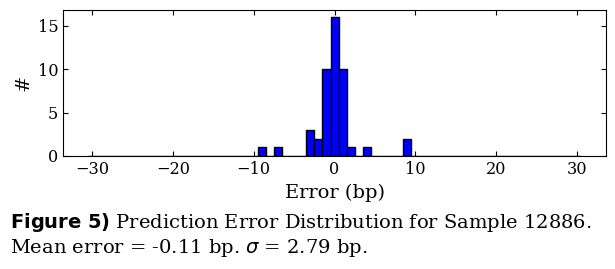

In [30]:
# Get a random sample from the HDF5 file
data_params = read_simulation_results(data_filename)
idx = np.random.randint(0, data_params.n_samples)
dyad_positions_sample, encoded_seq_sample, methylated_seq = read_simulation_results(data_filename, idx)

print(f"Loaded sample {idx} from {data_filename}")
print(f"Sequence length: {len(encoded_seq_sample)} bp")
print(f"Number of true dyads: {len(dyad_positions_sample)}")

# Predict dyads
dyads, probs = predict_dyads(loaded_model, encoded_seq_sample, device=device)

print(f"Number of predicted dyads: {len(dyads)}")

# Compute prediction errors for true dyad positions
error = [np.argmax(probs[i - 65 : i + 65]) - 65 for i in dyad_positions_sample]

# Plot error distribution for this sample
plot.new(fig_size=(6, 2))
plt.hist(np.array(error), range=(-30.5, 30.5), bins=61, color='blue', edgecolor='black')
plt.xlabel("Error (bp)")
plt.ylabel("#") 

plot.caption(f"Prediction Error Distribution for Sample {idx}. Mean error = {np.mean(error):.2f} bp. $\\sigma$ = {np.std(error):.2f} bp.")
plt.show()

## 7. Visualize predictions
Create detailed plots showing predicted vs. true dyad positions along the sequence.

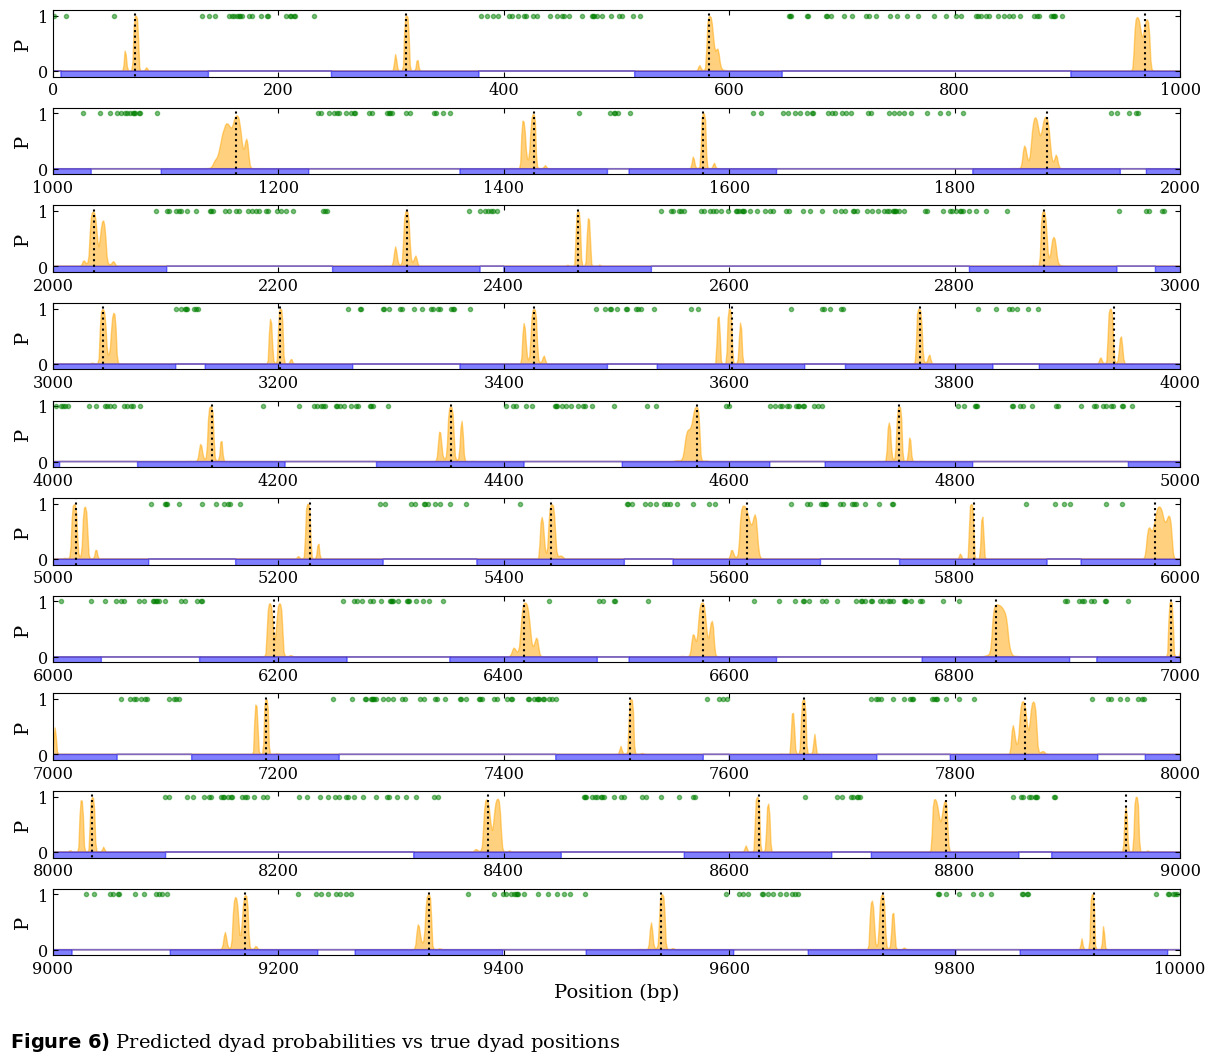

In [31]:
index = np.arange(len(encoded_seq_sample))
nucs = np.zeros_like(index)
nucs[dyad_positions_sample] = 1.0

for i in dyad_positions_sample:
    nucs[i - 65 : i + 65] = -1  # highlight nucleosome region


n_plots = 10
plot.new(fig_size = (12, n_plots), nrows= n_plots, sharex=False)
for i, panel in enumerate(plot.panels):

    panel.vlines(
        dyad_positions_sample, ymin=-1, ymax=2, color="black", linestyles="dotted", alpha=1
    )
    panel.fill_between(
        index, probs, label="Predicted Dyad Probability", color="orange", alpha=0.5
    )
    panel.fill_between(index, nucs, color="blue", alpha=0.5, label="True Dyad Positions")

    methylations = np.zeros_like(index)*np.nan
    methylations[index[encoded_seq_sample > 4]] = 1
    panel.plot(
        index,
        methylations,
        "o",
        label="Methylations",
        color="green",
        alpha=0.5,
        fillstyle="full",
        markersize=3,
    )

    panel.set_xlim(i * len(index) // n_plots, (i + 1) * len(index) // n_plots)
    panel.set_ylabel("P")
    panel.set_ylim(-0.1, 1.1)

plot.panels[-1].set_xlabel("Position (bp)")
plot.caption("Predicted dyad probabilities vs true dyad positions")
# plt.show()

## 8. Batch evaluation on multiple samples
Evaluate the model on multiple samples and compute aggregate statistics.

In [19]:
# Evaluate on multiple random samples
bins = np.linspace(-30.5, 30.5, 62)
all_errors = []
n_samples = 100

for idx in tqdm(np.random.choice(data_params.n_samples, size=n_samples, replace=False), desc="Computing prediction errors"):
    dyad_positions_sample, encoded_seq_sample, methylated_seq = read_simulation_results(data_filename, int(idx))
    dyads, probs = predict_dyads(loaded_model, encoded_seq_sample, device=device)
    
    # For each true dyad, find the closest predicted dyad and compute error
    seq_len = len(probs)
    for true_dyad in dyad_positions_sample:
        error = np.argmax(probs[true_dyad - 65 : true_dyad + 65]) - 65
        all_errors.append(error)


Computing prediction errors: 100%|██████████| 100/100 [00:12<00:00,  7.89it/s]


## 9. Fit error distribution
Fit the error distribution to a three-Gaussian model to characterize prediction accuracy.

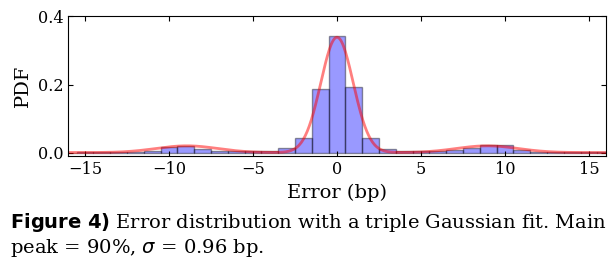

In [32]:
from scipy.optimize import curve_fit

def three_gaussians(x, fraction, std, shift, std2):
    """Model function: sum of three Gaussian distributions."""
    mean = 0
    gauss1 = (fraction / std) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    gauss2 = (0.5 * (1 - fraction) / std) * np.exp(-0.5 * ((x - mean - shift) / std2) ** 2)
    gauss3 = (0.5 * (1 - fraction) / std) * np.exp(-0.5 * ((x - mean + shift) / std2) ** 2)
    result = gauss1 + gauss2 + gauss3
    result = result / np.sum(result)  # Normalize area to 1
    result = result / np.median(np.diff(x))
    return result

# Create normalized histogram
histogram, x_hist = np.histogram(all_errors, bins=bins)
histogram = histogram / np.sum(histogram)  # Normalize to area=1
xhist = (x_hist[:-1] + x_hist[1:]) / 2  # bin centers

# Fit model
fit_params_init = {'fraction': 0.9, 'std': 4.0, 'shift': 9.5, 'std2': 1.0}
popt, pcov = curve_fit(three_gaussians, xhist, histogram, p0=[fit_params_init['fraction'], fit_params_init['std'], fit_params_init['shift'], fit_params_init['std2']])

# Plot results
plot.new(fig_size=(6, 2), fig_num=4)
plt.bar(xhist, histogram, width=np.diff(xhist)[0], align="center", alpha=0.4, color='blue', edgecolor='black')
plt.xlabel("Error (bp)")
plt.ylabel("PDF") 

three_gaussians_x = np.linspace(-30, 30, 1000)
legend_text = f"Main peak: {popt[0]:.0%}\nStd dev.: {popt[1]:.2f} bp"
plt.plot(three_gaussians_x, three_gaussians(three_gaussians_x, *popt), color='red', linewidth=2, label=legend_text, alpha=0.5)

plt.xlim(-16, 16)
plt.ylim(-0.01, 0.4)

plot.caption(f"Error distribution with a triple Gaussian fit. Main peak = {popt[0]:.0%}, $\\sigma$ = {popt[1]:.2f} bp.")
# plotter.save_figure("error_distribution")
plt.show()


## 10. Apply to custom sequence (optional)
You can also apply the model to your own encoded sequence.

In [21]:
# Example: Create or load your own encoded sequence
# custom_sequence = np.array([0, 1, 2, 3, 4, 5, 6, 7, ...])  # Your encoded DNA sequence (values 0-7)

# Uncomment to use:
# dyads_custom, probs_custom = predict_dyads(loaded_model, custom_sequence, device=device)
# print(f"Predicted {len(dyads_custom)} dyads in custom sequence")

print("To apply the model to your own sequence:")
print("1. Encode your DNA sequence (0-7 encoding: A=0, C=1, G=2, T=3, mA=4, mC=5, mG=6, mT=7)")
print("2. Call: dyads, probs = predict_dyads(loaded_model, your_encoded_sequence, device=device)")
print("3. Use probs array for per-position probabilities or dyads list for high-confidence positions")

To apply the model to your own sequence:
1. Encode your DNA sequence (0-7 encoding: A=0, C=1, G=2, T=3, mA=4, mC=5, mG=6, mT=7)
2. Call: dyads, probs = predict_dyads(loaded_model, your_encoded_sequence, device=device)
3. Use probs array for per-position probabilities or dyads list for high-confidence positions
